In [ ]:
import pandas as pd

df = pd.read_csv('output.csv')

In [ ]:
### FOR GOOGLE COLAB
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv('/content/drive/MyDrive/BT4012 Project/output.csv')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Feature Engineering

Binning Categorical Variables

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#Bin host_response_rate
df["Bin_host_response_rate"] = pd.cut(df["host_response_rate"], bins=bins, labels=labels, include_lowest=True)
df["Bin_host_response_rate"] = df["Bin_host_response_rate"].astype(int)

#Bin review_scores_rating
df["Bin_review_score_rating"] = pd.cut(df["review_scores_rating"], bins=bins, labels=labels, include_lowest=True)
df["Bin_review_score_rating"] = df["Bin_review_score_rating"].astype(int)

#Bin minimum_nights
df["Bin_Min_Nights"] = df["minimum_nights"].apply(lambda x: 1 if 0 <= x <= 10 else (2 if 11 <= x <= 20 else 3))

#Number of Accomodation: 1-3 accomodataes - 1; 4-6 accomodates - 2; 7 or more accomodates
df["Bin_Num_Accom"] = df["accommodates"].apply(lambda x: 1 if 1 <= x <= 3 else (2 if 4 <= x <= 6 else 3))

#Bin host_total_listings_count
list_bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
list_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df["Bin_Ttl_Listings"] = pd.cut(df["host_total_listings_count"], bins=list_bins, labels=list_labels, include_lowest=True)
df["Bin_Ttl_Listings"] = df["Bin_Ttl_Listings"].astype(int)

Log Transformation on Skewed Continuous Data Features

In [ ]:
import numpy as np

In [ ]:
skewed_features = ['price', 'number_of_reviews', 'city', 'reviews_per_month']

#log1p to add a constant, ensuring that values do not go to infinite
for sk_feat in skewed_features:
  df[f'lg_{sk_feat}'] = np.log1p(df[sk_feat])

# Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
columns_to_keep = [col for col in df.columns if col != 'fraud']
df_wo_labels = df[columns_to_keep]

Create new dataframe with processed features

In [ ]:
import itertools
selected_feat = ["host_identity_verified", "is_location_exact", "instant_bookable", "cancellation_policy", "room_type", "property_type", "amenities", "bathrooms", "bedrooms", "beds", "bed_type"]
lg_feat =  ['lg_price', 'lg_number_of_reviews', 'lg_city', 'lg_reviews_per_month']
bin_feat = ["Bin_Min_Nights", "Bin_Num_Accom", "Bin_Ttl_Listings", "Bin_review_score_rating", "Bin_host_response_rate"]
ttl_feat_list =list(itertools.chain(selected_feat, lg_feat,  bin_feat))

In [ ]:
processed_df = df[ttl_feat_list].copy()

In [ ]:
#categorical data features
cat_feat = list(itertools.chain(selected_feat, bin_feat))
#continuous data features
cont_feat = [col for col in processed_df.columns if col not in cat_feat]

In [ ]:
processed_fraud_df = pd.concat([processed_df, df['fraud']], axis = 1)

In [ ]:
bef_OHE_train_x, bef_OHE_test_x, bef_OHE_train_y, bef_OHE_test_y = train_test_split(processed_df, df["fraud"], test_size=0.20, random_state=42)

In [ ]:
bef_OHE_train_data, bef_OHE_test_data = processed_fraud_df[:len(bef_OHE_train_x)], processed_fraud_df[len(bef_OHE_train_x):]

# Feature Selection on Training Data: bef_OHE_train_data

#### Wrapper Method Feature Selection (Bi-directional Feature Elimination)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 10)

In [ ]:
import numpy as np
from sklearn import model_selection
cross_v =  model_selection.ShuffleSplit(n_splits = 10, test_size = 0.2, train_size = 0.8, random_state = 42)

In [ ]:
# Sequential Forward Floating Selection(sffs)
sffs = SFS(rfc,
         k_features=(5,len(ttl_feat_list)),
         forward=True,
         floating=True,
         cv=cross_v)

In [ ]:
# sffs.fit(bef_OHE_train_x, bef_OHE_train_y)
sffs_ttl_feat = list(sffs.k_feature_names_)

In [ ]:
sffs_ttl_feat = ['cancellation_policy', 'bed_type', 'lg_number_of_reviews', 'lg_reviews_per_month', 'Bin_Num_Accom','Bin_host_response_rate']

In [ ]:
sffs_ttl_feat

['cancellation_policy',
 'bed_type',
 'lg_number_of_reviews',
 'lg_reviews_per_month',
 'Bin_Num_Accom',
 'Bin_host_response_rate']

# Train-Test Split

In [ ]:
#Bi-directional Feature Selection
bidir_fs_processed_df = processed_df[sffs_ttl_feat]

In [ ]:
#Bidirectional Feature Selection OHE
bidirect_cat_feat = [cat for cat in cat_feat if cat in bidir_fs_processed_df]
ohe_bidir_process_df = pd.get_dummies(bidir_fs_processed_df, columns = bidirect_cat_feat)

In [ ]:
#Train Test Split for Bidirectional Feature Selection
bidir_train_x, bidir_test_x, bidir_train_y, bidir_test_y = train_test_split(ohe_bidir_process_df, df["fraud"], test_size=0.20, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the bidir_train_x data and transform it
bidir_x_processed_train_scaled = scaler.fit_transform(bidir_train_x)
# Transform bidir_test_x using the same scaler
bidir_x_processed_test_scaled = scaler.transform(bidir_test_x)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
bidir_train_x_smote, bidir_train_y_smote = smote.fit_resample(bidir_train_x, bidir_train_y)

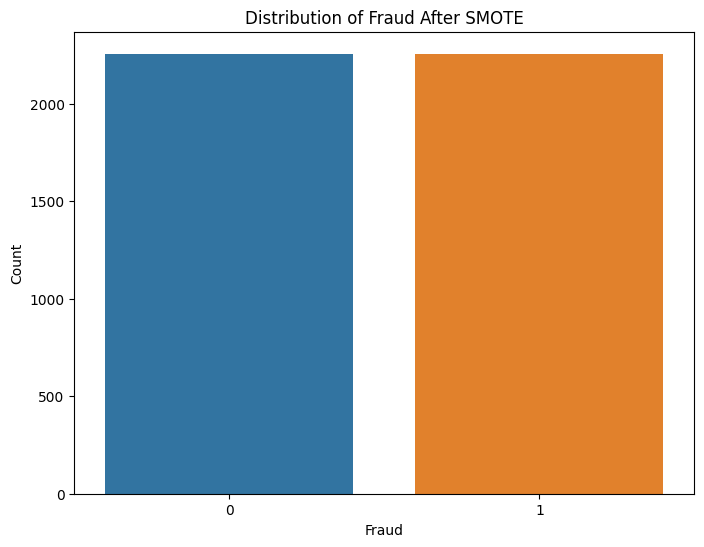

In [ ]:
# Plot the new distribution of fraud after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=bidir_train_y_smote)
plt.title("Distribution of Fraud After SMOTE")
plt.xlabel("Fraud")
plt.ylabel("Count")
plt.show()

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the bidir_train_x data and transform it
bidir_x_smote_train_scaled = scaler.fit_transform(bidir_train_x_smote)
# Transform bidir_test_x using the same scaler
bidir_x_smote_test_scaled = scaler.transform(bidir_test_x)

# Machine Learning Models (Wihout SMOTE)

Keep KNN, SVC, RandomForest, GradientBoostingClassifier, Neural Network (Deep Learning), run the confusionMatrix for these 5 models and evaluate in report.

In [ ]:
from sklearn import ensemble, gaussian_process, linear_model, neighbors, svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state = 42),
    ensemble.RandomForestClassifier(random_state = 42),

    #Logistic Regression
    linear_model.LogisticRegressionCV(random_state = 42),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier()

    ]

In [ ]:
bidir_processed_mla_columns = ["Model Name", "Model Parameters", "Bidir_Accuracy_Processed"]
bidir_processed_MLA_Results = pd.DataFrame(columns = bidir_processed_mla_columns)

In [ ]:
row_index = 0

for model in MLA:
  #model name
  model_name = model.__class__.__name__
  #model param
  model_param = str(model.get_params())
  #old data
  model.fit(bidir_x_processed_train_scaled, bidir_train_y)
  model_acc = accuracy_score(model.predict(bidir_x_processed_test_scaled), bidir_test_y)
  bidir_processed_MLA_Results.loc[row_index] = {"Model Name": model_name, "Model Parameters": model_param, "Bidir_Accuracy_Processed": model_acc}
  row_index += 1

#Dataframe
bidir_processed_MLA_Results.sort_values(by= "Bidir_Accuracy_Processed")

,Model Name,Model Parameters,Bidir_Accuracy_Processed
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.828452
3,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.836820
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.846583
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.853556


In [ ]:
bidir_processed_MLA_Results["Bidir_Accuracy_Processed"].mean()

0.8413528591352859

In [ ]:
# from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning (Without SMOTE)

In [ ]:
bs_n_estimator = [10, 50, 100, 200]
bs_ratio = [0.1, 0.25, 0.5, 0.75, 1.0]
bs_learn = [0.01, .03, .05, 0.1, 0.25]
bs_max_depth = [2, 4, 6, 8, 10]
bs_min_samp = [5, 10, .03, .05, .10]
bs_criterion = ['gini', 'entropy']
bs_bool = [True, False]
bs_seed = [42]
bs_neighbour = [1,3,5,7,9]
bs_weights = ['uniform', 'distance']

bs_param = [
    #AdaBoostClassifier Parameters
    [{
        'n_estimators': bs_n_estimator,
        'learning_rate': bs_learn,
        'random_state': bs_seed
    }],
    #Random Forest Parameters
    [{
        'n_estimators': bs_n_estimator,
        'criterion': bs_criterion,
        'oob_score': [True],
        'random_state': bs_seed,
        'max_depth': bs_max_depth
      }],
     #LogisticRegression Parameters
    [{
        'fit_intercept': bs_bool,
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'random_state': bs_seed
    }],
    # #Linear SVC Parameters
    #   [{
    #     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #       'C': [1,2,3,4,5], #default=1.0
    #       'gamma': bs_ratio, #edfault: auto
    #       'decision_function_shape': ['ovo', 'ovr'], #default:ovr
    #       'probability': [True],
    #       'random_state': bs_seed
    #   }],
     #K Nearest Neighbours Parameters
    [{
        'n_neighbors': bs_neighbour,
        'weights': bs_weights,
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "metric": ["minkowski", "euclidean", "manhattan"]
    }]
]

In [ ]:
for ml_model, ml_param in zip(MLA, bs_param):

  bs_search = GridSearchCV(estimator = ml_model, param_grid = ml_param, scoring = 'recall')
  #Fit train data on bayes_best search
  model_best_search = bs_search.fit(bidir_x_processed_train_scaled, bidir_train_y)
  #Get best search parameters
  model_best_param = model_best_search.best_params_
  #Print out the best parameter for the model
  print(f"The best parameter for {ml_model.__class__.__name__} is {model_best_param}")
  #set parameter for the model
  ml_model.set_params(**model_best_param)
  print("-"*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 42}
----------
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 10, 'oob_score': True, 'random_state': 42}
----------
The best parameter for LogisticRegressionCV is {'fit_intercept': False, 'random_state': 42, 'solver': 'newton-cg'}
----------
The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
----------


Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
#Build Voting classifier
estimators_class = [("abc", MLA[0]), ("log_reg", MLA[2]), ("knn", MLA[3])]
vote_class = VotingClassifier(estimators = estimators_class, voting = "soft")

#fit voting classifier
vote_class.fit(bidir_x_processed_train_scaled, bidir_train_y)

VotingClassifier(estimators=[('abc',
                              AdaBoostClassifier(learning_rate=0.01,
                                                 n_estimators=10,
                                                 random_state=42)),
                             ('log_reg',
                              LogisticRegressionCV(fit_intercept=False,
                                                   random_state=42,
                                                   solver='newton-cg')),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   weights='distance'))],
                 voting='soft')

# Model Evaluation (Without SMOTE)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
MLA.append(vote_class)

In [ ]:
MLA

[AdaBoostClassifier(learning_rate=0.01, n_estimators=10, random_state=42),
 RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=10,
                        oob_score=True, random_state=42),
 LogisticRegressionCV(fit_intercept=False, random_state=42, solver='newton-cg'),
 KNeighborsClassifier(metric='manhattan', weights='distance'),
 VotingClassifier(estimators=[('abc',
                               AdaBoostClassifier(learning_rate=0.01,
                                                  n_estimators=10,
                                                  random_state=42)),
                              ('log_reg',
                               LogisticRegressionCV(fit_intercept=False,
                                                    random_state=42,
                                                    solver='newton-cg')),
                              ('knn',
                               KNeighborsClassifier(metric='manhattan',
                                   

In [ ]:
#Create DataFrame
column_names = ["Model_Name", "Accuracy", "Precion_Score", "Recall_Score", "F1_Score", "ROC_Score"]
evaluation_df = pd.DataFrame(columns = column_names)

AdaBoostClassifier
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 42}


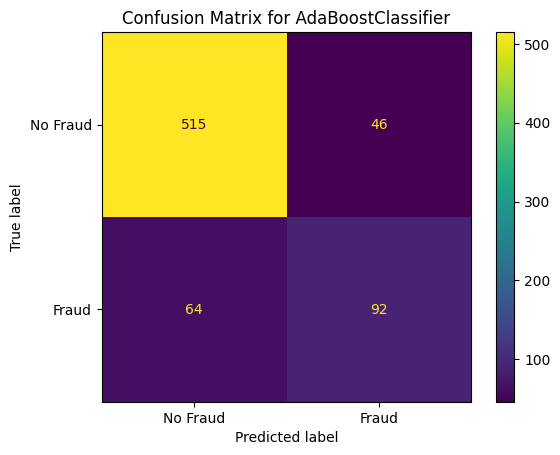

RandomForestClassifier
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


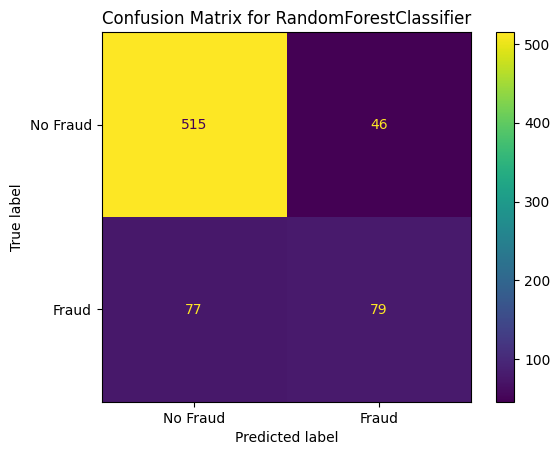

LogisticRegressionCV
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0}


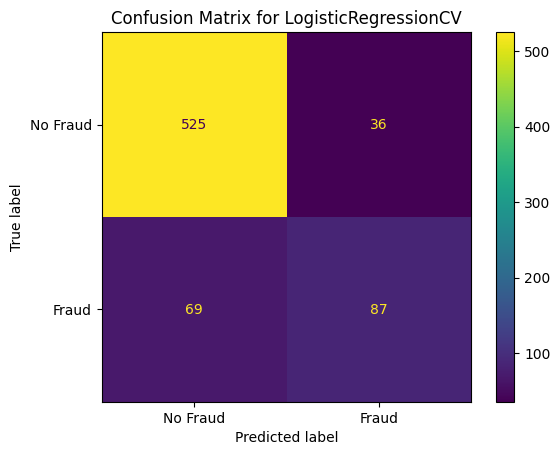

KNeighborsClassifier
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


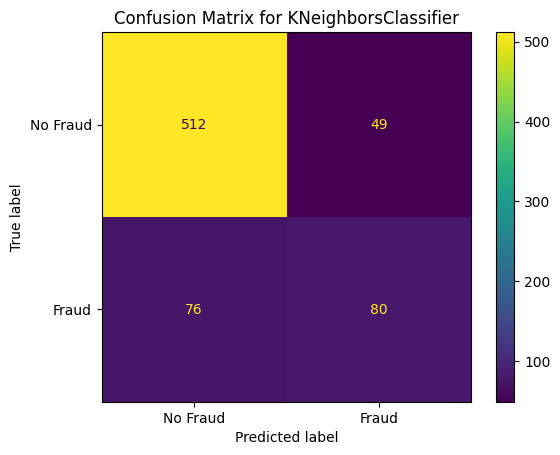

VotingClassifier
{'estimators': [('abc', AdaBoostClassifier(learning_rate=0.01, n_estimators=10, random_state=42)), ('log_reg', LogisticRegressionCV(fit_intercept=False, random_state=42, solver='newton-cg')), ('knn', KNeighborsClassifier(metric='manhattan', weights='distance'))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'soft', 'weights': None, 'abc': AdaBoostClassifier(learning_rate=0.01, n_estimators=10, random_state=42), 'log_reg': LogisticRegressionCV(fit_intercept=False, random_state=42, solver='newton-cg'), 'knn': KNeighborsClassifier(metric='manhattan', weights='distance'), 'abc__algorithm': 'SAMME.R', 'abc__base_estimator': 'deprecated', 'abc__estimator': None, 'abc__learning_rate': 0.01, 'abc__n_estimators': 10, 'abc__random_state': 42, 'log_reg__Cs': 10, 'log_reg__class_weight': None, 'log_reg__cv': None, 'log_reg__dual': False, 'log_reg__fit_intercept': False, 'log_reg__intercept_scaling': 1.0, 'log_reg__l1_ratios': None, 'log_reg__max_iter': 10

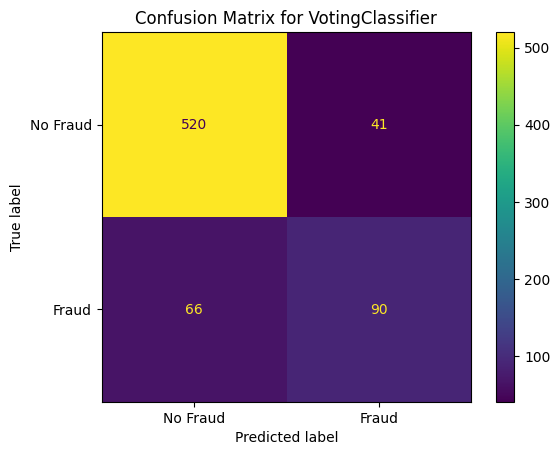

In [ ]:
row_index = 0
for ml_model in MLA:
    #model name
    model_name = ml_model.__class__.__name__
    print(model_name)
    print(ml_model.get_params())
    #make prediction
    ml_y_pred = ml_model.predict(bidir_x_processed_test_scaled)
    #confusion matrix
    confusion_matrix = metrics.confusion_matrix(bidir_test_y, ml_y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraud", "Fraud"])
    cm_display.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    #Run accuracy
    ml_acc = accuracy_score(bidir_test_y, ml_y_pred)
    #Run Pecision Score
    ml_precision = precision_score(bidir_test_y, ml_y_pred)
    #Run recall Score
    ml_recall = recall_score(bidir_test_y, ml_y_pred)
    #Run F1 Score
    ml_fl_score = f1_score(bidir_test_y, ml_y_pred)
    #ROC Score
    ml_ROC_Score = roc_auc_score(bidir_test_y,  ml_model.predict_proba(bidir_x_processed_test_scaled)[:,1])
    evaluation_df.loc[row_index] = {"Model_Name": model_name, "Accuracy": ml_acc, "Precion_Score": ml_precision, "Recall_Score": ml_recall, "F1_Score": ml_fl_score, \
                                    "ROC_Score": ml_ROC_Score}
    row_index += 1

In [ ]:
evaluation_df

,Model_Name,Accuracy,Precion_Score,Recall_Score,F1_Score,ROC_Score
0,AdaBoostClassifier,0.846583,0.666667,0.589744,0.625850,0.884501
1,RandomForestClassifier,0.828452,0.632000,0.506410,0.562278,0.845645
2,LogisticRegressionCV,0.853556,0.707317,0.557692,0.623656,0.894008
3,KNeighborsClassifier,0.825662,0.620155,0.512821,0.561404,0.822992
4,VotingClassifier,0.850767,0.687023,0.576923,0.627178,0.875189


In [ ]:
evaluation_df["Accuracy"].mean()

0.8410041841004183

# Machine Learning Models (With SMOTE)

In [ ]:
smote_MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(random_state = 42),
    ensemble.RandomForestClassifier(random_state = 42),

    #Logistic Regression
    linear_model.LogisticRegressionCV(random_state = 42),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier()
    ]

In [ ]:
bidir_smote_mla_columns = ["Model Name", "Model Parameters", "Bidir_Accuracy_Processed_SMOTE"]
bidir_smote_MLA_Results = pd.DataFrame(columns = bidir_smote_mla_columns)

In [ ]:
row_index = 0

for model in smote_MLA:
  #model name
  model_name = model.__class__.__name__
  #model param
  model_param = str(model.get_params())
  #old data
  model.fit(bidir_x_smote_train_scaled, bidir_train_y_smote)
  model_acc = accuracy_score(model.predict(bidir_x_smote_test_scaled), bidir_test_y)
  bidir_smote_MLA_Results.loc[row_index] = {"Model Name": model_name, "Model Parameters": model_param, "Bidir_Accuracy_Processed_SMOTE": model_acc}
  row_index += 1

#Dataframe
bidir_smote_MLA_Results.sort_values(by= "Bidir_Accuracy_Processed_SMOTE")

,Model Name,Model Parameters,Bidir_Accuracy_Processed_SMOTE
3,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.781032
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.800558
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.804742
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.807531


In [ ]:
bidir_smote_MLA_Results["Bidir_Accuracy_Processed_SMOTE"].mean()

0.798465829846583

# Hyperparameter Tuning (With SMOTE)

With SMOTE

In [ ]:
for ml_model, ml_param in zip(smote_MLA, bs_param):

  bs_search = GridSearchCV(estimator = ml_model, param_grid = ml_param, cv=3, scoring = 'recall')
  #Fit train data on bayes_best search
  model_best_search = bs_search.fit(bidir_x_smote_train_scaled, bidir_train_y_smote)
  #Get best search parameters
  model_best_param = model_best_search.best_params_
  #Print out the best parameter for the model
  print(f"The best parameter for {ml_model.__class__.__name__} is {model_best_param}")
  #set parameter for the model
  ml_model.set_params(**model_best_param)
  print("-"*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 10, 'random_state': 42}
----------
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200, 'oob_score': True, 'random_state': 42}
----------
The best parameter for LogisticRegressionCV is {'fit_intercept': False, 'random_state': 42, 'solver': 'saga'}
----------
The best parameter for KNeighborsClassifier is {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
----------


Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
#Build Voting classifier
estimators_class = [("abc", smote_MLA[0]), ("log_reg", smote_MLA[2]), ("rfc", smote_MLA[1])]
vote_class = VotingClassifier(estimators = estimators_class, voting = "soft")

#fit voting classifier
vote_class.fit(bidir_x_smote_train_scaled, bidir_train_y_smote)

VotingClassifier(estimators=[('abc',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=10,
                                                 random_state=42)),
                             ('log_reg',
                              LogisticRegressionCV(fit_intercept=False,
                                                   random_state=42,
                                                   solver='saga')),
                             ('rfc',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     oob_score=True,
                                                     random_state=42))],
                 voting='soft')

In [ ]:
smote_MLA.append(vote_class)

# Model Evaluation (With SMOTE)

AdaBoostClassifier
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.1, 'n_estimators': 10, 'random_state': 42}


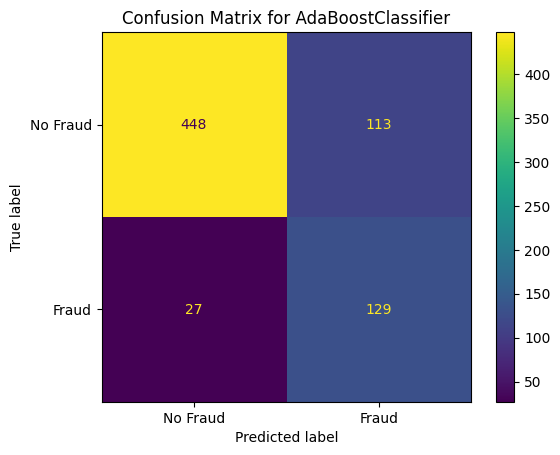

RandomForestClassifier
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


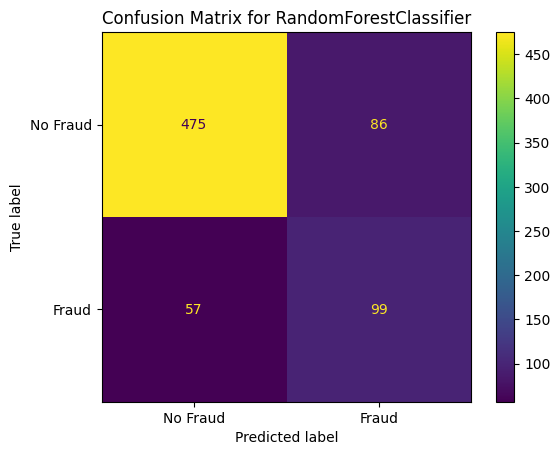

LogisticRegressionCV
{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'refit': True, 'scoring': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}


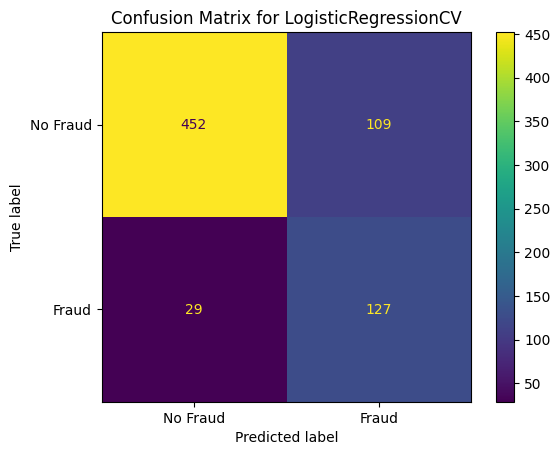

KNeighborsClassifier
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


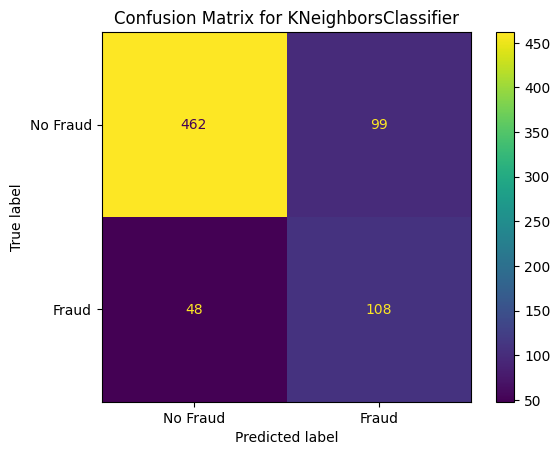

VotingClassifier
{'estimators': [('abc', AdaBoostClassifier(learning_rate=0.1, n_estimators=10, random_state=42)), ('log_reg', LogisticRegressionCV(fit_intercept=False, random_state=42, solver='saga')), ('rfc', RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=42))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'soft', 'weights': None, 'abc': AdaBoostClassifier(learning_rate=0.1, n_estimators=10, random_state=42), 'log_reg': LogisticRegressionCV(fit_intercept=False, random_state=42, solver='saga'), 'rfc': RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=42), 'abc__algorithm': 'SAMME.R', 'abc__base_estimator': 'deprecated', 'abc__estimator': None, 'abc__learning_rate': 0.1, 'abc__n_estimators': 10, 'abc__random_state': 42, 'log_reg__Cs': 10, 'log_reg__class_weight': None, 'log_reg__cv': None, 'log_reg__dual': False, 'log_reg__fit_intercept': False,

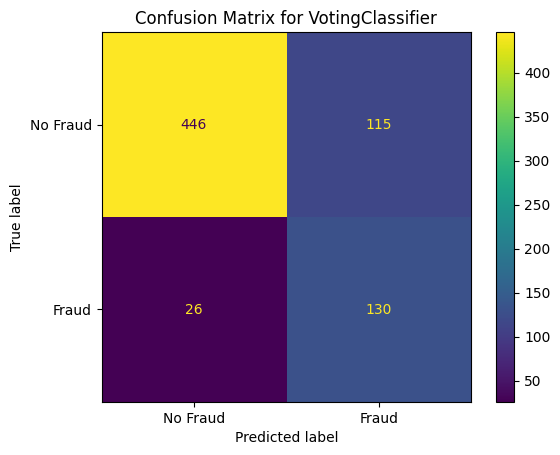

In [ ]:
column_names = ["Model_Name", "Accuracy", "Precion_Score", "Recall_Score", "F1_Score", "ROC_Score"]
w_smote_evaluation_df = pd.DataFrame(columns = column_names)
row_index = 0
for ml_model in smote_MLA:
    #model name
    model_name = ml_model.__class__.__name__
    print(model_name)
    print(ml_model.get_params())

    #make prediction
    ml_y_pred = ml_model.predict(bidir_x_smote_test_scaled)

    #confusion matrix
    confusion_matrix = metrics.confusion_matrix(bidir_test_y, ml_y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["No Fraud", "Fraud"])
    cm_display.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    #Run accuracy
    ml_acc = accuracy_score(bidir_test_y, ml_y_pred)

    #Run Pecision Score
    ml_precision = precision_score(bidir_test_y, ml_y_pred)

    #Run recall Score
    ml_recall = recall_score(bidir_test_y, ml_y_pred)

    #Run F1 Score
    ml_fl_score = f1_score(bidir_test_y, ml_y_pred)

    #ROC Score
    ml_ROC_Score = roc_auc_score(bidir_test_y, ml_model.predict_proba(bidir_x_smote_test_scaled)[:,1])
    w_smote_evaluation_df.loc[row_index] = {"Model_Name": model_name, "Accuracy": ml_acc, "Precion_Score": ml_precision, "Recall_Score": ml_recall, "F1_Score": ml_fl_score, \
                                            "ROC_Score": ml_ROC_Score}
    row_index += 1

In [ ]:
w_smote_evaluation_df

,Model_Name,Accuracy,Precion_Score,Recall_Score,F1_Score,ROC_Score
0,AdaBoostClassifier,0.804742,0.533058,0.826923,0.648241,0.887683
1,RandomForestClassifier,0.800558,0.535135,0.634615,0.580645,0.842549
2,LogisticRegressionCV,0.807531,0.538136,0.814103,0.647959,0.895253
3,KNeighborsClassifier,0.794979,0.521739,0.692308,0.595041,0.835436
4,VotingClassifier,0.803347,0.530612,0.833333,0.648379,0.894865


In [ ]:
w_smote_evaluation_df["Accuracy"].mean()

0.8022315202231519